In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB6,EfficientNetB7,InceptionV3,InceptionResNetV2
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
classes=[]
filename=r"/content/drive/MyDrive/Data/MRI Images/"
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [4]:
X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)        


100%|██████████| 105/105 [00:02<00:00, 41.00it/s]


In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()


In [6]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

print(y_train)

[3 3 2 ... 3 3 0]


In [7]:
EfficientNetB6=EfficientNetB6(weights=None, include_top=False,input_shape=(image_size,image_size,3))


In [8]:
tf.random.set_seed(79)
model = EfficientNetB6.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNetB6.input, outputs = model)
opt = Adam(
    learning_rate=0.000023,
    epsilon=1e-08,
    clipnorm=1.0)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 


In [9]:
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 161, 161, 3)  0           ['normalization[0][0]']      

In [10]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=70,
    batch_size=8,callbacks=[early_stopping_cb])


Epoch 1/70
348/348 [==============================] - 154s 268ms/step - loss: 1.4419 - accuracy: 0.3181 - val_loss: 1.4085 - val_accuracy: 0.2866
Epoch 2/70
348/348 [==============================] - 87s 250ms/step - loss: 1.3966 - accuracy: 0.3332 - val_loss: 1.3591 - val_accuracy: 0.2947
Epoch 3/70
348/348 [==============================] - 89s 256ms/step - loss: 1.3974 - accuracy: 0.3228 - val_loss: 3.8258 - val_accuracy: 0.3293
Epoch 4/70
348/348 [==============================] - 89s 256ms/step - loss: 1.4070 - accuracy: 0.3307 - val_loss: 2.2147 - val_accuracy: 0.3354
Epoch 5/70
348/348 [==============================] - 88s 253ms/step - loss: 1.3821 - accuracy: 0.3314 - val_loss: 2.5587 - val_accuracy: 0.3943


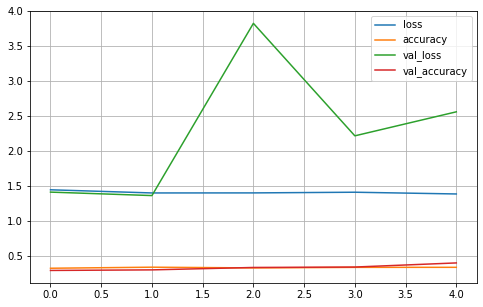

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)


In [12]:
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 4s 199ms/step - loss: 1.3591 - accuracy: 0.2947


In [13]:
print('Accuracy: %f' % (accuracy*100))

Accuracy: 29.471543


In [14]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 29.472 
 loss : 1.359


In [15]:
y_test_labels=lb.inverse_transform(y_test)
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred)

In [16]:
pd.Series(pred_labels).value_counts()

glioma_tumor        451
pituitary_tumor      25
meningioma_tumor      8
no_tumor              8
dtype: int64

Text(70.8, 0.5, 'Predicted class')

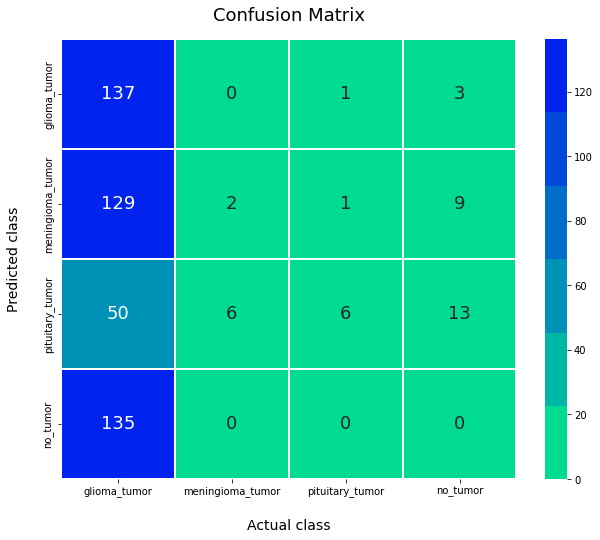

In [17]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [18]:

print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

    glioma_tumor       0.30      0.97      0.46       141
meningioma_tumor       0.25      0.01      0.03       141
 pituitary_tumor       0.75      0.08      0.14        75
        no_tumor       0.00      0.00      0.00       135

        accuracy                           0.29       492
       macro avg       0.33      0.27      0.16       492
    weighted avg       0.27      0.29      0.16       492

